In [12]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy import stats
import glob
import seaborn as sns
# %matplotlib notebook
%matplotlib inline
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

from fitter import Fitter, get_common_distributions, get_distributions

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Estimation of CAFOs sizes distribution for the states of:

- Ohio
- Pennsylvania
- Indiana
- Michigan
- Wisconsin

Import data files

In [2]:
CAFOs_Ohio = pd.read_csv('USCafosData/Ohio_Merged_Results_Pcredits0_REC0_None.csv', sep=",", header=0, index_col=0)
CAFOs_Michigan = pd.read_csv('USCafosData/Michigan_Merged_Results_Pcredits0_REC0_None.csv', sep=",", header=0, index_col=0)
CAFOs_Wisconsin = pd.read_csv('USCafosData/Wisconsin_Merged_Results_Pcredits0_REC0_None.csv', sep=",", header=0, index_col=0)
CAFOs_Pennsylvania = pd.read_csv('USCafosData/Pennsylvania_Merged_Results_Pcredits0_REC0_None.csv', sep=",", header=0, index_col=0)
CAFOs_Indiana = pd.read_csv('USCafosData/Indiana_Merged_Results_Pcredits0_REC0_None.csv', sep=",", header=0, index_col=0)


CAFOs_Dict ={'Ohio':CAFOs_Ohio['Animal Units'],
             'Michigan':CAFOs_Michigan['Animal Units'],
             'Wisconsin':CAFOs_Wisconsin['Animal Units'],
             'Pennsylvania':CAFOs_Pennsylvania['Animal Units'],
             'Indiana':CAFOs_Indiana['Animal Units']}

CAFOs_Merged = pd.DataFrame(data = CAFOs_Dict)
CAFOs_Merged.describe().to_csv('CAFOsStatisticsSummary'+'.csv')
CAFOs_Merged

,Ohio,Michigan,Wisconsin,Pennsylvania,Indiana
0,4000.0,1500.0,1000,612.04,2000.0
1,2070.0,7601.0,2013,1509.75,1650.0
2,1085.0,2000.0,1214,1737.42,750.0
3,820.0,4500.0,1604,384.34,300.0
4,1200.0,4500.0,860,1070.86,575.0
5,3600.0,2900.0,2792,720.52,500.0
6,1072.0,950.0,1500,915.30,1200.0
7,3020.0,2375.0,1105,660.18,560.0
8,9800.0,500.0,2521,113.92,600.0
9,1838.0,1990.0,2531,619.30,557.0


In [3]:
CAFOs_Merged.describe()

,Ohio,Michigan,Wisconsin,Pennsylvania,Indiana
count,53.000000,144.000000,284.000000,136.000000,119.000000
mean,2415.245283,2461.527778,2619.771127,1445.716176,1574.411765
std,1588.246879,1333.813099,2074.645165,1540.918260,1738.811387
min,820.000000,420.000000,238.000000,113.920000,300.000000
25%,1500.000000,1347.500000,1500.000000,631.032500,490.500000
50%,2000.000000,2225.000000,1971.000000,1194.415000,750.000000
75%,2800.000000,3420.000000,2941.000000,1685.487500,1959.500000
max,9800.000000,7601.000000,13569.000000,14180.950000,10560.000000


In [4]:
def NumberOfBins(data_list): #computing the optimal number of bins using the Freedman-Diaconis rule
    # Computing IQR
    Q1 = data_list.quantile(0.25)
    Q3 = data_list.quantile(0.75)
    IQR = Q3 - Q1

    bins_width = 2*IQR/(data_list.count()**(1/3)) #Freedman-Diaconis rule

    bins_number = int(round((data_list.max()-data_list.min())/bins_width,0))
    return bins_number

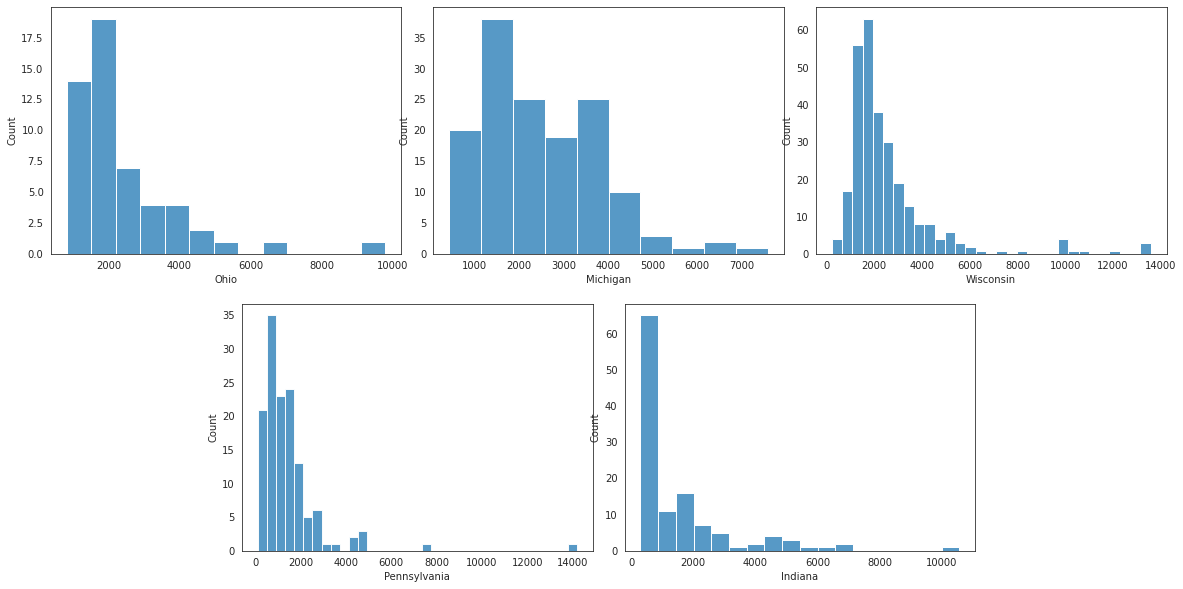

In [5]:
sns.set_style('white')

# fig, ax =plt.subplots(2,3,figsize=(20,10))

# ax_rows = np.arange(0,len(ax)) #This is because it is 2 dimensional array
# ax_columns = np.arange(0,len(ax[0])) #This is because it is 2 dimensional array

# ax_matrix = []#This is because it is 2 dimensional array
# for i in ax_rows:
#     for ii in ax_columns:
#         ax_element = [i,ii]
#         ax_matrix.append(ax_element) 
        
# sns.histplot(CAFOs_Merged[state].dropna(), ax=ax[ax_number[0]][ax_number[1]])


fig = plt.figure(figsize=(20,10))
gs = gridspec.GridSpec(2, 6)

count = 0
for state in CAFOs_Merged.columns:
    if count < 3: #This is for centering the last row of plots
        ax = plt.subplot(gs[0, 2 * count:2 * count + 2])
    else:
        ax = plt.subplot(gs[1, 2 * count - 5:2 * count + 2 - 5])
              
    sns.histplot(CAFOs_Merged[state].dropna(), ax=ax)
    count = count+1

# fig.delaxes(ax[ax_matrix[-1][0],ax_matrix[-1][1]])

In [ ]:
# fitting_values = CAFOs_Ohio['Animal Units'].values

# fit_variable = Fitter(fitting_values,
#                distributions=[
#                               'gamma',
#                               'lognorm',
#                               "beta",
#                               "gennorm",
#                               "t",
#                               "norm",
#                                "lognorm",
#                                "dweibull"]
#                                      )
# fit_variable.fit()
# fit_variable.summary()

Fits_CAFOs_Summary = dict()
for state in CAFOs_Merged:
    fitting_values = CAFOs_Merged[state].dropna().values

    fit_variable = Fitter(fitting_values,
                   distributions=[
                                  'gamma',
                                  'lognorm',
                                  "beta",
                                  "gennorm",
                                  "t",
                                  "norm",
                                   "lognorm",
                                   "dweibull"]
                                         )
    fit_variable.fit()
    print(state)
    fit_variable.summary()
    Fits_CAFOs_Summary[state] = fit_variable.summary()
    fit_variable.summary().plot()

In [ ]:
Fits_CAFOs_Summary

In [ ]:
Fits_CAFOs_Summary = dict()
for state in CAFOs_Merged:
    fitting_values = CAFOs_Merged[state].dropna().values

    fit_variable = Fitter(fitting_values,
                   distributions=get_common_distributions()
                                         )
    fit_variable.fit()
    print(state)
    fit_variable.summary()
    Fits_CAFOs_Summary[state] = fit_variable.summary()
    fit_variable.summary().plot()

# After a visual analysis of the distributions we select the following ones:

## Generalized normal distributions for all cases, discarding Michigan that shows a not clear short of binomial dstribution

Ohio
Michigan
Wisconsin
Pennsylvania
Indiana


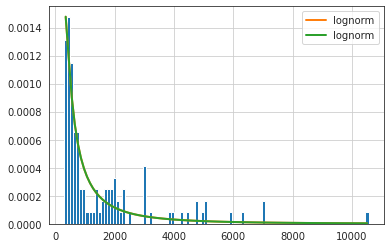

In [7]:
Fits_CAFOs_Summary = dict()
for state in CAFOs_Merged:
    fitting_values = CAFOs_Merged[state].dropna().values
    
    if CAFOs_Merged.describe().loc['count'][state] <100:

        fit_variable = Fitter(fitting_values,
                       distributions=['gennorm']
                                             )
        
    elif state == 'Indiana':
        fit_variable = Fitter(fitting_values,
                       distributions=['lognorm']
                                             )
        
    else:
        fit_variable = Fitter(fitting_values,
                       distributions=['gennorm']
                                             )
    
    
    fit_variable.fit()
    print(state)
    fit_variable.summary()
    Fits_CAFOs_Summary[state] = fit_variable.summary()
    # fit_variable.summary().plot()
    fit_variable.plot_pdf()

In [16]:
# a = fit_variable.summary(plotsavename="a")  # s is an instance of Series
# fig = ax[0][0].get_figure()
fit_variable = Fitter(CAFOs_Merged['Ohio'].dropna().values,
                       distributions=['gennorm']
                                             )
fit_variable.fit()
fit_variable.fitted_param["gennorm"]

(0.563217072107863, 2000.0000000181408, 250.54296180173372)

In [13]:
dist = getattr(stats, 'gennorm')
dist.fit(CAFOs_Merged['Ohio'].dropna().values)

stat='count',

(0.563217072107863, 2000.0000000181408, 250.54296180173372)